In [1]:
import pandas as pd
import numpy as np

import string
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import re


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.options.display.max_colwidth = 200

In [3]:
df = pd.read_csv('csv_files/anxiety_tweets.csv')

In [4]:
df.tail(5)

,text,user,date,retweet,mention,hashtags,location
9995,Finished 2 seasons. I don't know. It gives me anxiety and makes me never want to speak to a man again.,mmmeghan,2019-11-22 02:19:36+00:00,0,NaN,NaN,NaN
9996,On a serious note I hate when people joke about and laugh about my rush anxiety. Like it really actually bothers me so please just don’t.,justlikestephxx,2019-11-22 02:05:33+00:00,0,NaN,NaN,NaN
9997,I think I’m having an anxiety attach? Is it like a shaking feelings were can feel all of your limps.,momozelly,2019-11-22 02:04:16+00:00,0,NaN,NaN,NaN
9998,Me tryna deal with anxiety depression Netflix and Apple Music bills https://twitter.com/memes_bizarre/status/1195701303047004160/video/1,smittty_93,2019-11-22 01:58:51+00:00,0,NaN,NaN,NaN
9999,"Interviews take way more out of you, I feel much more stress and anxiety that a common work day lmao",excusemeimjulia,2019-11-22 01:35:30+00:00,0,NaN,NaN,NaN


In [5]:
stop_words = stopwords.words('english')

#add punctuation char's to stopwords list
stop_words += list(string.punctuation)
stop_words += ['anxiety','feel', 'give', 'giving', 'help', 'said', 'also', 'rt', 'gave', 'like', 'going', 'even']

In [7]:
def remove_urls(text):
    return re.sub(r'http\S+','', text)
   

In [8]:
df['text'] = df['text'].apply(remove_urls)

Observing removal of url in df

In [10]:
df.tail(2)

,text,user,date,retweet,mention,hashtags,location
9998,Me tryna deal with anxiety depression Netflix and Apple Music bills,smittty_93,2019-11-22 01:58:51+00:00,0,NaN,NaN,NaN
9999,"Interviews take way more out of you, I feel much more stress and anxiety that a common work day lmao",excusemeimjulia,2019-11-22 01:35:30+00:00,0,NaN,NaN,NaN


In [9]:
lemmatizer = WordNetLemmatizer()

def preprocess(df_text):
    tokens = word_tokenize(df_text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words and len(token) > 3]
    
    lemmatized =[]
    
    for w in stopwords_removed:
        lemmatized.append(lemmatizer.lemmatize(w))
        
    processed = list(filter(lambda x: x.isalpha(), lemmatized))  
        
    return processed

In [10]:
df['text'] = df['text'].apply(preprocess)

In [11]:
all_words = [word for tokens in df['text'] for word in tokens]
tweet_lengths = [len(tokens) for tokens in df['text']]
vocab = sorted(list(set(all_words)))

print('{} tokens total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))


97690 tokens total, with a vocabulary size of 13630
Max tweet length is 32


In [12]:
word_length = []
for word in all_words:
    word_length.append(len(word))

In [13]:
print('average word size is {}'.format( sum(word_length) / len(word_length)))

average word size is 6.2710001023646225


#### Observing df after stop words have been removed, text has been tokenized, lemmatized, url's removed, and any remaining non alpha characters have been stripped 

In [14]:
df.tail(2)

,text,user,date,retweet,mention,hashtags,location
9998,"[tryna, deal, depression, netflix, apple, music, bill]",smittty_93,2019-11-22 01:58:51+00:00,0,NaN,NaN,NaN
9999,"[interview, take, much, stress, common, work, lmao]",excusemeimjulia,2019-11-22 01:35:30+00:00,0,NaN,NaN,NaN


### Exploring the Processed Text

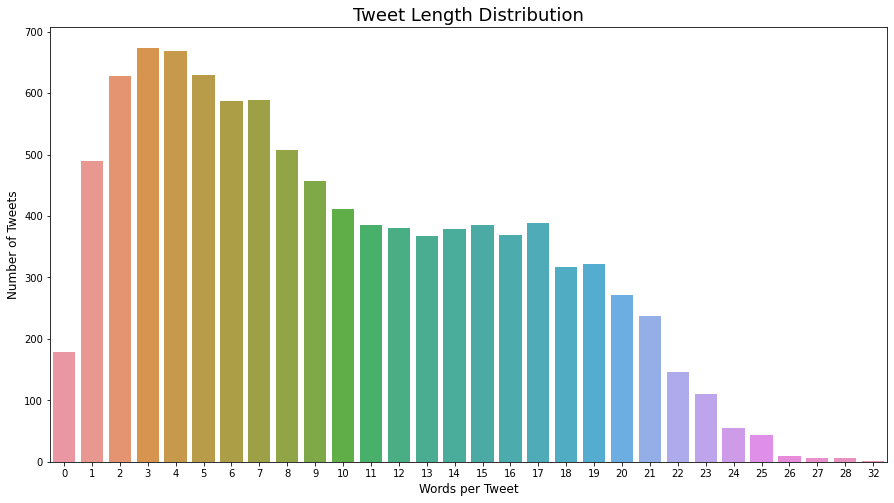

In [36]:
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

* Distribution of tweet lengths is right-skewed.
* high concentration of tweets containing only 1-7 tokens
* additional filtering should be done to remove tweets having less than 3 tokens, as I dont believe they will add much value to the model

In [15]:
less_than_3_tokens = df[df['text'].apply(lambda x: len(x) <= 3)].index

In [16]:
df.drop(less_than_3_tokens, inplace = True)

In [17]:
all_words = [word for tokens in df['text'] for word in tokens]
tweet_lengths = [len(tokens) for tokens in df['text']]
vocab = sorted(list(set(all_words)))

print('{} tokens total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

93922 tokens total, with a vocabulary size of 13350
Max tweet length is 32


In [18]:
print(97690 - 93922)
print(13630 - 13350)

3768
280


* 3768 tweets(documents) have been removed from the dataset
* 280 words(tokens)have been removed from the overall vocab

* let's have another look at the distrubition

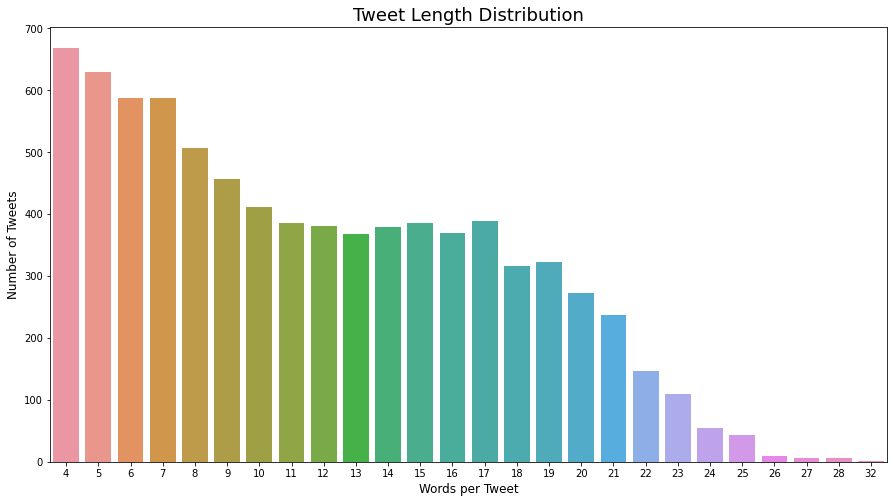

In [19]:
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

In [20]:
flat_words = [item for sublist in df['text'] for item in sublist]

In [21]:
word_freq = FreqDist(flat_words)

In [22]:
word_freq.most_common(25)

[('time', 854),
 ('people', 774),
 ('depression', 608),
 ('much', 548),
 ('know', 501),
 ('stress', 469),
 ('really', 449),
 ('thing', 438),
 ('need', 437),
 ('attack', 428),
 ('make', 407),
 ('social', 396),
 ('today', 389),
 ('work', 354),
 ('right', 347),
 ('think', 344),
 ('fear', 344),
 ('take', 343),
 ('good', 339),
 ('life', 328),
 ('want', 319),
 ('would', 315),
 ('back', 313),
 ('feeling', 303),
 ('year', 295)]

In [23]:
#retrieve word and count from FreqDist tuples

most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

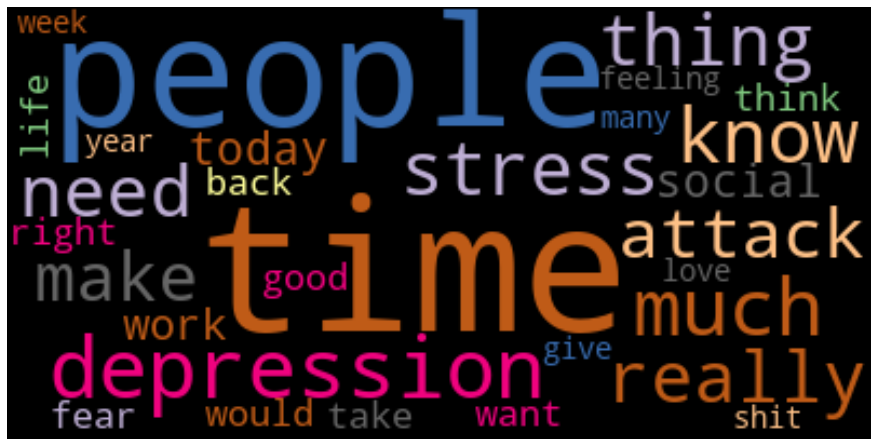

In [26]:
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_30_cloud.png')


plt.show()

### Modeling

In [27]:
text_dict = Dictionary(df.text)

In [28]:
text_dict.filter_extremes(no_below = 5, no_above = .90)

In [29]:
txt_out = text_dict.token2id

# for k, v in txt_out.items():
#     print(k,v)

In [30]:
# text_dict.save_as_text('tweet_text_dict.txt')

In [31]:
tweets_bow = [text_dict.doc2bow(tweet) for tweet in df['text']]

In [32]:
df['text'][9999]

['interview', 'take', 'much', 'stress', 'common', 'work', 'lmao']

In [33]:
tweets_bow[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1)]

In [34]:
k = 5
tweets_lda = LdaModel(tweets_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)

In [35]:
tweets_lda.show_topics()

[(0,
  '0.019*"work" + 0.015*"take" + 0.014*"stress" + 0.014*"need" + 0.014*"time" + 0.013*"much" + 0.011*"today" + 0.010*"sleep" + 0.009*"next" + 0.009*"watch"'),
 (1,
  '0.034*"know" + 0.027*"people" + 0.025*"depression" + 0.017*"nice" + 0.016*"social" + 0.016*"family" + 0.015*"please" + 0.015*"really" + 0.015*"fucking" + 0.015*"think"'),
 (2,
  '0.022*"attack" + 0.019*"much" + 0.018*"give" + 0.017*"really" + 0.014*"make" + 0.014*"know" + 0.014*"never" + 0.013*"would" + 0.013*"something" + 0.013*"people"'),
 (3,
  '0.018*"news" + 0.014*"respond" + 0.013*"good" + 0.013*"disorder" + 0.012*"fear" + 0.012*"hard" + 0.011*"trying" + 0.011*"still" + 0.010*"love" + 0.010*"literally"'),
 (4,
  '0.030*"people" + 0.020*"real" + 0.019*"body" + 0.019*"social" + 0.018*"find" + 0.018*"good" + 0.018*"depression" + 0.018*"want" + 0.016*"next" + 0.016*"actually"')]

**From Eyeballing** 

* There does not seem to be a clear distinction between topics. 

* Topic 0 appears to be about the struggles of working from home. Although if thats the case, I'm surprised "covid",  "covid-19", "coronavirus", etc. are not included here.

* Topic 1 may be about social isolation? 

* Topic 2 ?

* Topic 3 Media, reactions to media

* Topic 4 Contains much of the same structure as topic 1


In [37]:
def format_topics_sentences(ldamodel=None, corpus=tweets_bow, texts=df['text']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[tweets_bow]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=tweets_lda, corpus=tweets_bow, texts=df['text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3222,"know, people, depression, nice, social, family, please, really, fucking, think","[okay, totally, understand, specific, struggle, queer, japanese, japanese, people, open, learning, personally, mean, exist, applies, racism, phobia, list, go]"
1,1,4.0,0.6260,"people, real, body, social, find, good, depression, want, next, actually","[thing, know, returning, hair, salon, excitement, normal, salon, barber, shop, long, island, enters, phase]"
2,2,0.0,0.8795,"work, take, stress, need, time, much, today, sleep, next, watch","[well, information, would, useful, month, avoided, wasted, every, single, time, person, came, slightly, close, entering, general, vicinity]"
3,3,1.0,0.5567,"know, people, depression, nice, social, family, please, really, fucking, think",NaN
4,4,2.0,0.8135,"attack, much, give, really, make, know, never, would, something, people","[mostly, afraid, really, misunderstanding, past, kept, recently, reached, point, desperation, something, surprisingly, attentive, validating, glad, worried, nothing]"
5,5,0.0,0.5764,"work, take, stress, need, time, much, today, sleep, next, watch","[damn, stressed, time, need, find, outlet, else, crazy, roof]"
6,6,2.0,0.3979,"attack, much, give, really, make, know, never, would, something, people","[eating, cause, mind, lmaoo, need, gain, weight]"
7,7,1.0,0.3746,"know, people, depression, nice, social, family, please, really, fucking, think","[would, called, police, forcibly, restrained, attack, allison, think, justiceforjonathansalcido]"
8,8,0.0,0.6983,"work, take, stress, need, time, much, today, sleep, next, watch",NaN
9,9,2.0,0.5688,"attack, much, give, really, make, know, never, would, something, people","[suck, prevalent, time, breathe, allow, ground, best, good, something, make, happy, write, anxious, driven, thought]"


In [41]:
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6731,"people, worst, social, phone, like, life, think, call, time, many","[okay, totally, understand, specific, struggle, queer, japanese, japanese, people, open, learning, personally, mean, exist, applies, racism, phobia, list, go]"
1,1,0.0,0.7752,"people, real, coronavirus, make, level, pandemic, time, face, reason, social","[thing, know, returning, hair, salon, excitement, normal, salon, barber, shop, long, island, enters, phase]"
2,2,0.0,0.7335,"people, real, coronavirus, make, level, pandemic, time, face, reason, social","[well, information, would, useful, month, avoided, wasted, every, single, time, person, came, even, slightly, close, entering, general, vicinity]"
3,3,3.0,0.7082,"people, worst, social, phone, like, life, think, call, time, many","[greatest, lately]"
4,4,3.0,0.7542,"people, worst, social, phone, like, life, think, call, time, many","[mostly, afraid, really, misunderstanding, past, kept, recently, reached, point, desperation, something, surprisingly, attentive, validating, glad, worried, nothing]"
5,5,5.0,0.6509,"like, time, really, thing, know, going, people, take, roof, today","[damn, stressed, time, need, find, outlet, else, crazy, roof]"
6,6,7.0,0.4661,"stress, sleep, help, depression, pain, next, time, family, relief, tonight","[eating, cause, mind, lmaoo, need, gain, weight]"
7,7,2.0,0.5455,"give, morning, much, since, listening, work, handle, test, train, time","[would, called, police, forcibly, restrained, attack, allison, think, justiceforjonathansalcido]"
8,8,3.0,0.5586,"people, worst, social, phone, like, life, think, call, time, many",[summe]
9,9,1.0,0.4313,"like, much, fucking, right, attack, give, fuck, people, getting, bitch","[suck, prevalent, time, breathe, allow, ground, best, even, good, something, make, happy, write, anxious, driven, thought]"


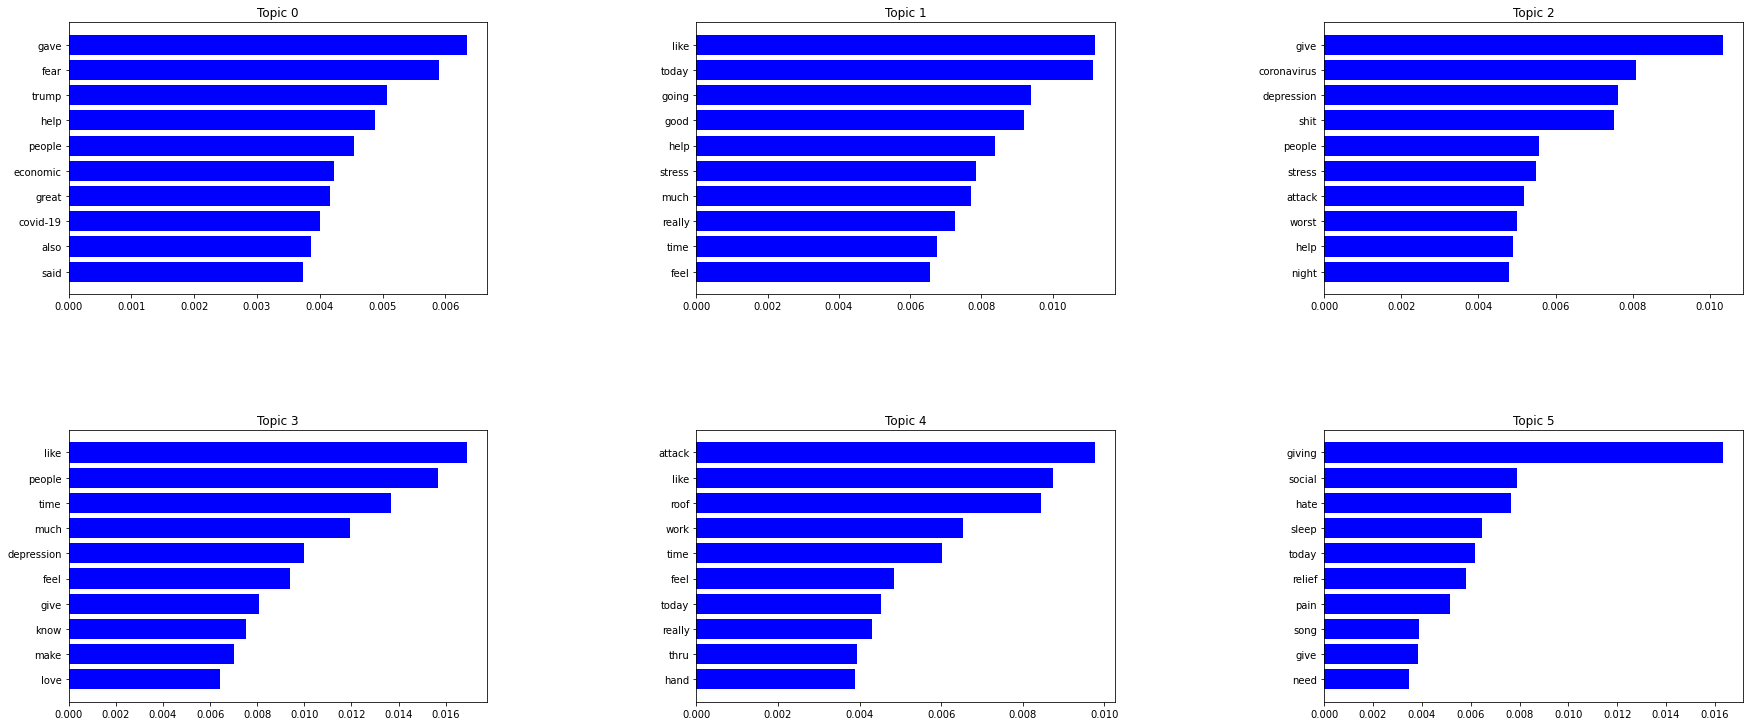

In [65]:
def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
plot_top_words()

In [113]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(tweets_lda, tweets_bow, dictionary=tweets_lda.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.182391 -0.099169       1        1  30.338938
3     -0.121362 -0.142539       2        1  23.866524
2     -0.091726  0.077922       3        1  22.190725
1      0.036575  0.269980       4        1  15.118615
4      0.358904 -0.106193       5        1   8.485196, topic_info=        Term        Freq       Total Category  logprob  loglift
7     people  849.000000  849.000000  Default  30.0000  30.0000
18      know  691.000000  691.000000  Default  29.0000  29.0000
65    attack  395.000000  395.000000  Default  28.0000  28.0000
470     work  445.000000  445.000000  Default  27.0000  27.0000
342     news  339.000000  339.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
157     many   67.107857  236.476654   Topic5  -4.5900   1.2073
125     love   65.515396  271.566650   Topic5  -4.6140   1.0449
94      made   60.255180  134.693390   Topic5  -4.6977   1.6624
436  someone   60.661453  173.236786   Topic5  -4.6910   1.4175
24     thing   61.212231  352.362488   Topic5  -4.6819   0.7165

[292 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1894      4  0.992190    acting
279       1  0.047386  actually
279       3  0.517297  actually
279       4  0.019744  actually
279       5  0.414627  actually
...     ...       ...       ...
253       2  0.076458      year
253       3  0.114686      year
253       4  0.034406      year
1148      5  0.987915      york
1094      2  0.980819   youtube

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

## Next Steps


* Using n-grams to connect words that occur together commonly, such as “mental”, and “health”. A bi-gram would retain “mental_health” so that the model reads it as one token.
* Additional filtering of commonly occurring words that aren’t providing any meaningful context.
* Calculating a Coherence Score, and find optimal parameters for k topics, number of passes, etc.
* Collect a larger corpus of tweets, and experiment with a more diverse dataset.